# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">Neural Networks</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Modeling process for predicting defaults</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

### Dataset

In [1]:
# sourcery skip: remove-redundant-fstring
import pandas as pd
import numpy as np

dataset_path = (
    f"/Users/deburky/Documents/python/data/"
    f"lpetrocelli-czech-financial-dataset-real-anonymized-transactions/data"
)

dataset_trans = pd.read_csv(f"{dataset_path}/trans.csv")

dict_to_rename = {
    "VYDAJ": "EXPENSE",
    "PRIJEM": "INCOME",
    "VYBER": "WITHDRAWAL",
    "VYBER KARTOU": "CARD_WITHDRAWAL",
    "PREVOD NA UCET": "TRANSFER_TO_ACCOUNT",
    "PREVOD Z UCTU": "TRANSFER_FROM_ACCOUNT",
    "VKLAD": "DEPOSIT",
}

dataset_trans["type"] = dataset_trans["type"].map(dict_to_rename)
dataset_trans["operation"] = dataset_trans["operation"].map(dict_to_rename)
dataset_trans["operation"] = np.where(
    dataset_trans["operation"].isna(), "TRANSFER_TO_ACCOUNT", dataset_trans["operation"]
)


# convert date lookin like 930101 to 1993-01-01
def convert_date(date):
    date = str(date)
    year = int(f"19{date[:2]}")
    month = int(date[2:4])
    day = int(date[4:])
    return pd.Timestamp(year=year, month=month, day=day)


dataset_trans["date"] = dataset_trans["date"].apply(convert_date)

dataset_trans["amount"] = np.where(
    dataset_trans["type"] == "EXPENSE",
    -dataset_trans["amount"],
    dataset_trans["amount"],
)

dataset_trans["amount_to_balance"] = (
    abs(dataset_trans["amount"]) / dataset_trans["balance"]
)
dataset_trans["amount_balance_interaction"] = (
    dataset_trans["amount"] * dataset_trans["balance"]
)

dataset_trans.drop(columns=["k_symbol", "bank", "account"], inplace=True)

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_53333/605650422.py:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_trans = pd.read_csv(f"{dataset_path}/trans.csv")


In [2]:
# remove rows with account_id having less than a series of 10 transactions
dataset_trans_trx = dataset_trans.groupby('account_id').filter(lambda x: len(x) > 10)

### Labels

In [3]:
dataset_default = pd.read_csv(f"{dataset_path}/loan.csv")

bad_labels = ["B", "D"]

dataset_default["default_label"] = np.where(
    dataset_default["status"].isin(bad_labels), 1, 0
)

defaults = dataset_default.query("default_label == 1")

# convert date to datetime
defaults["date"] = defaults["date"].apply(convert_date)

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_53333/1079541685.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaults["date"] = defaults["date"].apply(convert_date)


In [4]:
default_rate = dataset_default['default_label'].mean()
print(f"Default rate: {default_rate:.2%}")

Default rate: 11.14%


### Training data

In [5]:
# please keep only account_id in dataset_trans which is present in dataset_default
list_of_ids = dataset_default['account_id'].unique()
dataset_trans_filtered = dataset_trans_trx[dataset_trans_trx['account_id'].isin(list_of_ids)]

training_data = pd.merge_asof(
    dataset_trans_filtered,
    defaults[['account_id', 'date', 'default_label']],
    by='account_id',
    on='date',
    direction='backward'
)

training_data['default_label'] = training_data['default_label'].fillna(0).astype(int)

### Sequence transformation

In [6]:
# keep only data starting from 1994
print(len(training_data))
training_data = training_data.query("date >= '1994-01-01'").copy()
print(len(training_data))
training_data.sort_values(['account_id', 'date', 'trans_id'], inplace=True)

191556
186907


In [7]:
# calculate for each account ID difference in balance between two consecutive transactions
training_data['balance_delta'] = training_data.groupby('account_id')['balance'].diff()
training_data['balance_delta'] = np.where(training_data['balance'].isna(), 0, training_data['balance'])

<Axes: xlabel='date'>

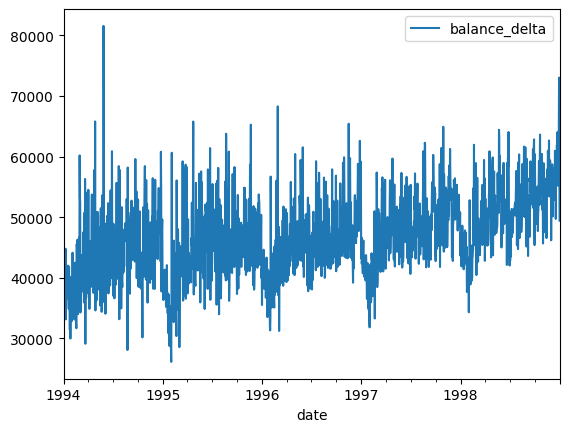

In [8]:
training_data.groupby('date').agg({'balance_delta': 'mean'}).plot()

### RNN
We define a baseline model using a simple RNN (Recurrent Neural Network).

In [48]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

torch.manual_seed(0)

seq_id = "account_id"
features = ["amount", "balance", "amount_to_balance", "balance_delta"]
label = "default_label"
max_sequence_length, batch_size = 50, 32


# Define a custom Dataset class to handle sequences
class AccountSequenceDataset(Dataset):
    def __init__(self, data, max_sequence_length=10, seq_id="account_id"):
        self.data = data.groupby(seq_id)
        self.max_sequence_length = max_sequence_length
        self.sequences = []
        self.labels = []
        for _, group in self.data:
            if len(group) > max_sequence_length:
                sequence = group[features].values[:max_sequence_length]
            else:
                sequence = np.pad(
                    group[features].values,
                    ((0, max_sequence_length - len(group)), (0, 0)),
                )
            self.sequences.append(torch.tensor(sequence, dtype=torch.float32))
            self.labels.append(
                torch.tensor(group[label].values[0], dtype=torch.float32)
            )

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


# Define the RNN model
class SequentialModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SequentialModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Prepare training and test datasets
X = training_data[features]
A = training_data[seq_id]
y = training_data[label]

training_data_df = pd.concat([X, y, A], axis=1)
ix_train, ix_test = train_test_split(
    training_data_df.index, stratify=y, test_size=0.3, random_state=42
)

training_data_train = training_data_df.loc[ix_train]
training_data_test = training_data_df.loc[ix_test]

# Perform feature scaling
scaler = StandardScaler()
training_data_train[features] = scaler.fit_transform(training_data_train[features]) * 50
training_data_test[features] = scaler.transform(training_data_test[features]) * 50

# Create datasets and dataloaders
train_dataset = AccountSequenceDataset(training_data_train, max_sequence_length=max_sequence_length)
test_dataset = AccountSequenceDataset(training_data_test, max_sequence_length=max_sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, and optimizer
model = SequentialModel(input_size=len(features), hidden_size=64, num_classes=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

# Training loop
losses = []
for epoch in range(2000):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze(1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}")

# Make inference on the test set
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze(1)
        predictions.extend(torch.sigmoid(outputs).numpy())
        true_labels.extend(y_batch.numpy())

# Calculate performance metric
gini = 2 * roc_auc_score(true_labels, predictions) - 1
print(f"Gini: {gini:.2%}")

Epoch 0, Loss 0.6267
Epoch 100, Loss 0.4101
Epoch 200, Loss 0.3251
Epoch 300, Loss 0.2358
Epoch 400, Loss 0.1687
Epoch 500, Loss 0.1210
Epoch 600, Loss 0.0938
Epoch 700, Loss 0.0964
Epoch 800, Loss 0.0767
Epoch 900, Loss 0.0729
Epoch 1000, Loss 0.0767
Epoch 1100, Loss 0.0481
Epoch 1200, Loss 0.0744
Epoch 1300, Loss 0.0859
Epoch 1400, Loss 0.0588
Epoch 1500, Loss 0.0371
Epoch 1600, Loss 0.0362
Epoch 1700, Loss 0.0655
Epoch 1800, Loss 0.0463
Epoch 1900, Loss 0.0727
Gini: 66.87%


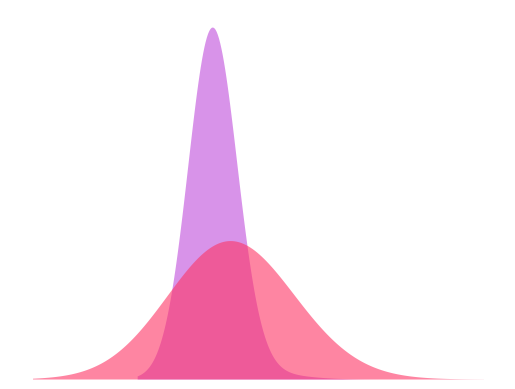

In [49]:
from matplotlib import pyplot as plt
import seaborn as sns

predictions_rnn = np.array(predictions)
y_test_rnn = np.array(true_labels)

common_kde_params = dict(
    fill=True, alpha=0.6, linewidth=0.0, bw_method=5.0, bw_adjust=0.5
)
sns.kdeplot(
    predictions_rnn[y_test_rnn == 0], 
    label='Non-default', 
    color='#be4bdb', 
    **common_kde_params # type: ignore
)
sns.kdeplot(
    predictions_rnn[y_test_rnn == 1], 
    label='Default',
    color='#fe3465', 
    **common_kde_params # type: ignore
)
plt.axis('off')
plt.show()

### LSTM

We define an LSTM (Long Short-Term Memory) model as a challenger.

* LSTM was developed by J. Schmidhuber and Sepp Hochreiter in 1997;
* It is a type of RNN that is capable of learning long-term dependencies;
* It is composed of a cell, an input gate, an output gate, and a forget gate. 

The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

In [53]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

torch.manual_seed(0)

seq_id = "account_id"
features = ["amount", "balance", "amount_to_balance", "balance_delta"]
label = "default_label"
max_sequence_length, batch_size = 50, 32


# Define a custom Dataset class to handle sequences
class AccountSequenceDataset(Dataset):
    def __init__(self, data, max_sequence_length=10, seq_id="account_id"):
        self.data = data.groupby(seq_id)
        self.max_sequence_length = max_sequence_length
        self.sequences = []
        self.labels = []
        for _, group in self.data:
            if len(group) > max_sequence_length:
                sequence = group[features].values[:max_sequence_length]
            else:
                sequence = np.pad(
                    group[features].values,
                    ((0, max_sequence_length - len(group)), (0, 0)),
                )
            self.sequences.append(torch.tensor(sequence, dtype=torch.float32))
            self.labels.append(
                torch.tensor(group[label].values[0], dtype=torch.float32)
            )

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        batch_size = x.size(0)  # Extract batch size from input
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])  # Select the output of the last time step
        
        return out

# Prepare training and test datasets
X = training_data[features]
A = training_data[seq_id]
y = training_data[label]

training_data_df = pd.concat([X, y, A], axis=1)
ix_train, ix_test = train_test_split(
    training_data_df.index, stratify=y, test_size=0.3, random_state=42
)

training_data_train = training_data_df.loc[ix_train]
training_data_test = training_data_df.loc[ix_test]

# Perform feature scaling
scaler = StandardScaler()
training_data_train[features] = scaler.fit_transform(training_data_train[features]) * 50
training_data_test[features] = scaler.transform(training_data_test[features]) * 50

# Create datasets and dataloaders
train_dataset = AccountSequenceDataset(training_data_train, max_sequence_length=max_sequence_length)
test_dataset = AccountSequenceDataset(training_data_test, max_sequence_length=max_sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, and optimizer
model = LSTMModel(input_size=len(features), hidden_size=32, num_layers=2, output_size=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

# Training loop
losses = []
for epoch in range(500):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze(1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}")

# Make inference on the test set
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze(1)
        predictions.extend(torch.sigmoid(outputs).numpy())
        true_labels.extend(y_batch.numpy())

# Calculate performance metric
gini = 2 * roc_auc_score(true_labels, predictions) - 1
print(f"Gini: {gini:.2%}")

Epoch 0, Loss 0.6269
Epoch 100, Loss 0.1758
Epoch 200, Loss 0.0958
Epoch 300, Loss 0.1062
Epoch 400, Loss 0.0741
Gini: 73.30%


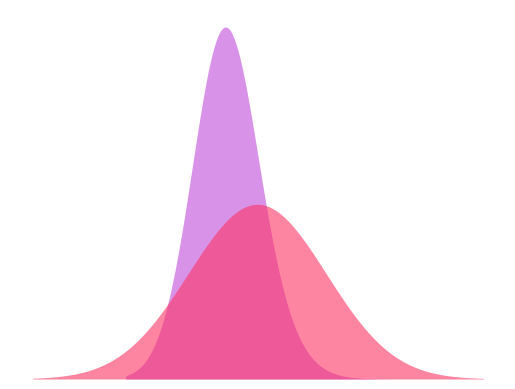

In [54]:
from matplotlib import pyplot as plt
import seaborn as sns

predictions_lstm = np.array(predictions)
y_test_lstm = np.array(true_labels)

common_kde_params = dict(
    fill=True, alpha=0.6, linewidth=0.0, bw_method=5.0, bw_adjust=0.5
)
sns.kdeplot(
    predictions_lstm[y_test_lstm == 0], 
    label='Non-default', 
    color='#be4bdb', 
    **common_kde_params  # type: ignore
)
sns.kdeplot(
    predictions_lstm[y_test_lstm == 1], 
    label='Default', 
    color='#fe3465', 
    **common_kde_params # type: ignore
)
plt.axis('off')
plt.show()

### Transformer

We define a Transformer model as a challenger.

The architecture is based on the paper "Attention Is All You Need".

* Transformer was proposed by Vaswani et al. in 2017;
* It is a type of neural network architecture that is based on self-attention mechanism;
* It is composed of an encoder and a decoder, each of which is composed of multiple layers.

In [55]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

torch.manual_seed(0)

seq_id = "account_id"
features = ["amount", "balance", "amount_to_balance", "balance_delta"]
label = "default_label"
max_sequence_length, batch_size = 50, 32


# Define a custom Dataset class to handle sequences
class AccountSequenceDataset(Dataset):
    def __init__(self, data, max_sequence_length=10, seq_id="account_id"):
        self.data = data.groupby(seq_id)
        self.max_sequence_length = max_sequence_length
        self.sequences = []
        self.labels = []
        for _, group in self.data:
            if len(group) > max_sequence_length:
                sequence = group[features].values[:max_sequence_length]
            else:
                sequence = np.pad(
                    group[features].values,
                    ((0, max_sequence_length - len(group)), (0, 0)),
                )
            self.sequences.append(torch.tensor(sequence, dtype=torch.float32))
            self.labels.append(
                torch.tensor(group[label].values[0], dtype=torch.float32)
            )

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_size,
        d_model,
        nhead,
        num_encoder_layers,
        dim_feedforward,
        max_sequence_length,
        output_size,
    ):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.d_model = d_model
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.dim_feedforward = dim_feedforward
        self.max_sequence_length = max_sequence_length
        self.output_size = output_size

        self.embedding = nn.Linear(input_size, d_model)
        self.positional_encoding = nn.Parameter(
            torch.zeros(1, max_sequence_length, d_model)
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_encoder_layers
        )
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x


# Prepare training and test datasets
X = training_data[features]
A = training_data[seq_id]
y = training_data[label]

training_data_df = pd.concat([X, y, A], axis=1)
ix_train, ix_test = train_test_split(
    training_data_df.index, stratify=y, test_size=0.3, random_state=42
)

training_data_train = training_data_df.loc[ix_train]
training_data_test = training_data_df.loc[ix_test]

# Perform feature scaling
scaler = StandardScaler()
training_data_train[features] = scaler.fit_transform(training_data_train[features]) * 50
training_data_test[features] = scaler.transform(training_data_test[features]) * 50

# Create datasets and dataloaders
train_dataset = AccountSequenceDataset(training_data_train, max_sequence_length=max_sequence_length)
test_dataset = AccountSequenceDataset(training_data_test, max_sequence_length=max_sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, and optimizer
model = TransformerModel(
    input_size=len(features),
    d_model=36,
    nhead=6,
    num_encoder_layers=3,
    dim_feedforward=96,
    max_sequence_length=50,
    output_size=1
)

lr = 0.00057624872164786

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

# Training loop
losses = []
for epoch in range(100):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze(1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}")

# Make inference on the test set
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze(1)
        predictions.extend(torch.sigmoid(outputs).numpy())
        true_labels.extend(y_batch.numpy())

# Calculate performance metric
gini = 2 * roc_auc_score(true_labels, predictions) - 1
print(f"Gini: {gini:.2%}")

Epoch 0, Loss 0.1004
Gini: 83.36%


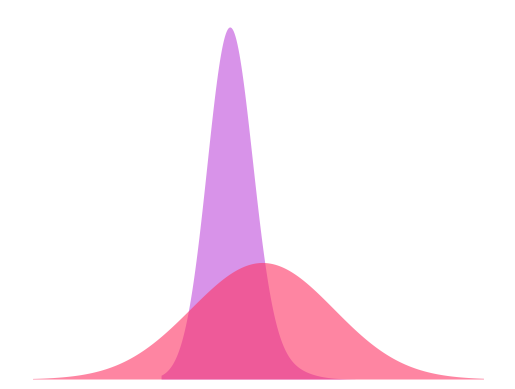

In [56]:
from matplotlib import pyplot as plt
import seaborn as sns

predictions_transf = np.array(predictions)
y_test_transf = np.array(true_labels)

common_kde_params = dict(
    fill=True, alpha=0.6, linewidth=0.0, bw_method=5.0, bw_adjust=0.5
)
sns.kdeplot(
    predictions_transf[y_test_transf == 0],
    label='Non-default', 
    color='#be4bdb', 
    **common_kde_params # type: ignore
)
sns.kdeplot(
    predictions_transf[y_test_transf == 1], 
    label='Default', 
    color='#fe3465', 
    **common_kde_params # type: ignore
)
plt.axis('off')
plt.show()

## Performance

### Discriminatory power

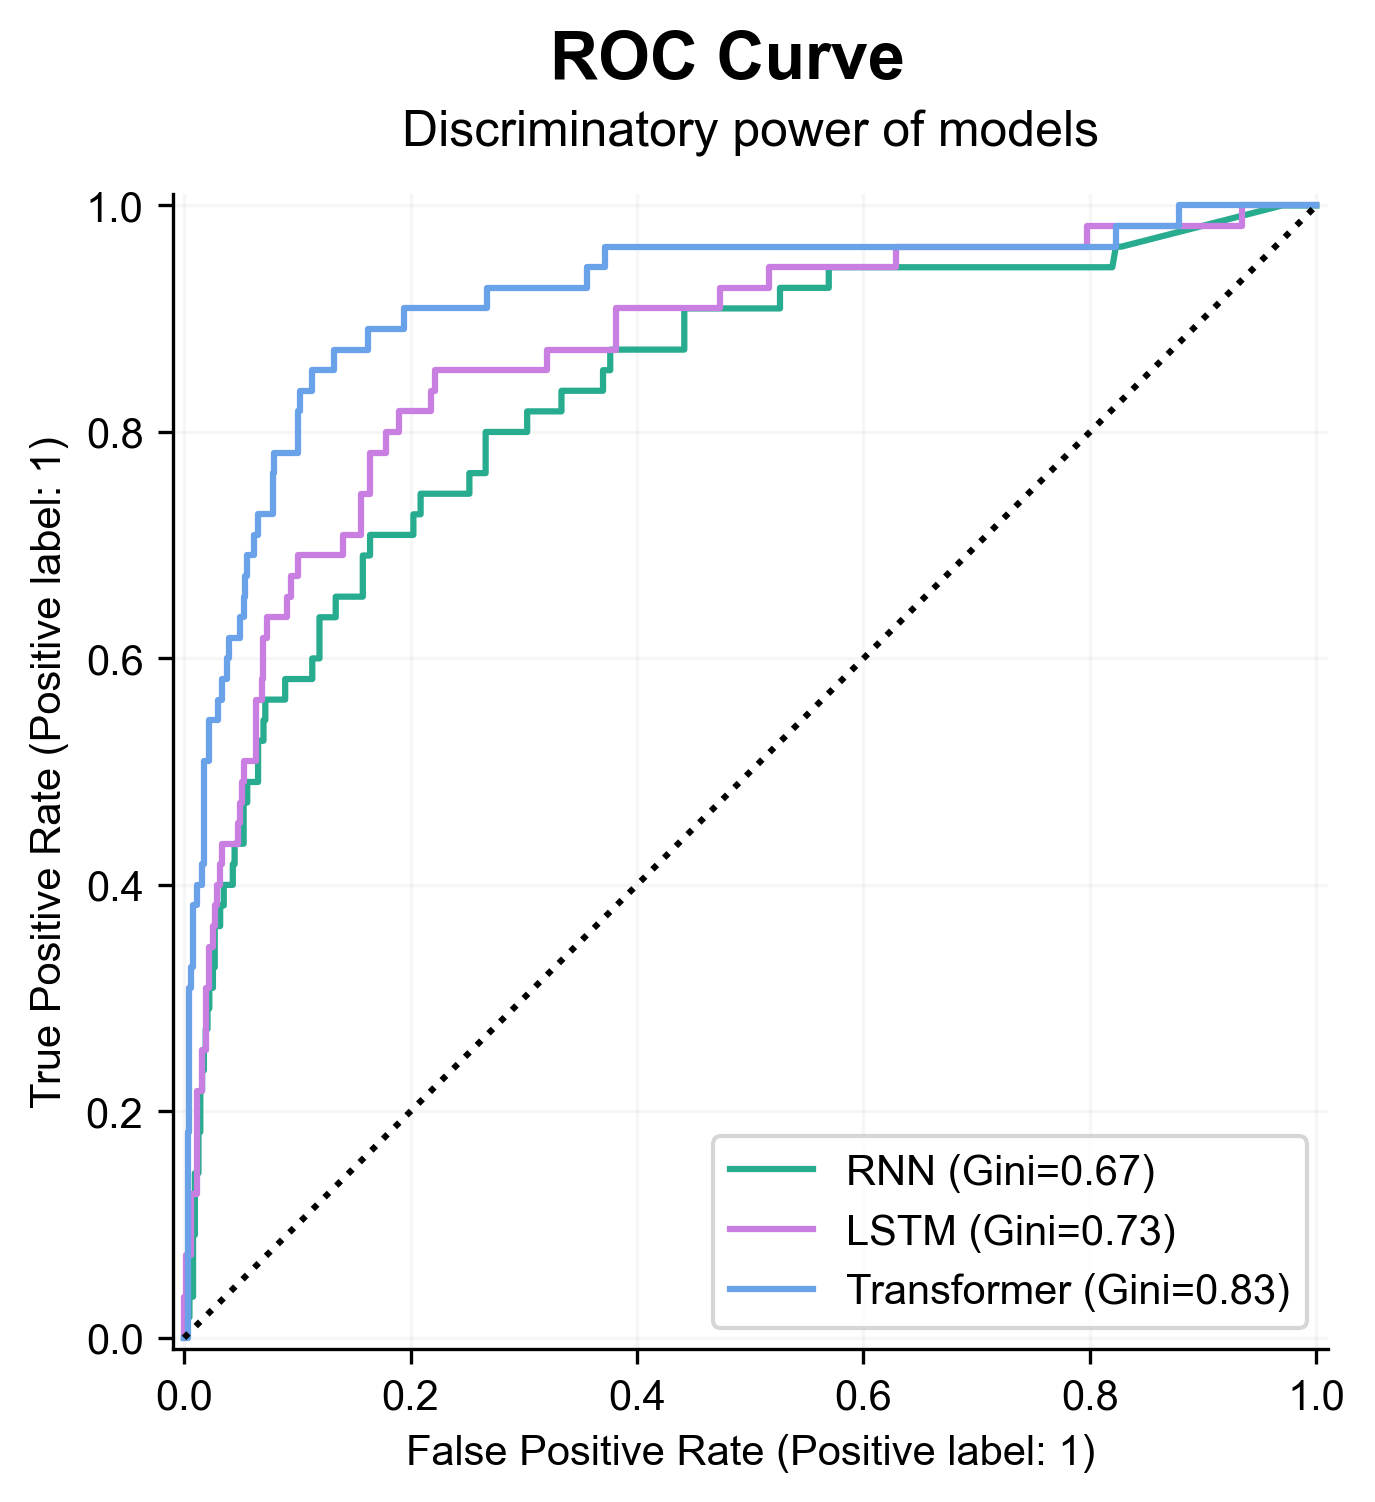

In [57]:
from sklearn.metrics import RocCurveDisplay
from matplotlib import pyplot as plt

# set font to Arial
plt.rcParams['font.sans-serif'] = 'Arial'

plt.figure(figsize=(6, 5), dpi=300)
ax_roc_auc_curve = plt.axes()
colors = ['#27ac8f', '#c97ee2', '#69a2e9']

gini_rnn = 2 * roc_auc_score(y_test_rnn, predictions_rnn) - 1
gini_lstm = 2 * roc_auc_score(y_test_lstm, predictions_lstm) - 1
gini_transformer = 2 * roc_auc_score(y_test_transf, predictions_transf) - 1


RocCurveDisplay.from_predictions(
    y_test_rnn, 
    predictions_rnn, 
    ax=ax_roc_auc_curve, 
    name="RNN",
    label=f'RNN (Gini={gini_rnn:.2f})',
    color=colors[0]
)
RocCurveDisplay.from_predictions(
    y_test_lstm, 
    predictions_lstm, 
    ax=ax_roc_auc_curve, 
    name="LSTM",
    label=f'LSTM (Gini={gini_lstm:.2f})',
    color=colors[1]
)
RocCurveDisplay.from_predictions(
    y_test_transf,
    predictions_transf,
    ax=ax_roc_auc_curve,
    name="Transformer",
    label=f'Transformer (Gini={gini_transformer:.2f})',
    color=colors[2],
)

ax_roc_auc_curve.grid()
ax_roc_auc_curve.plot([0, 1], [0, 1], "k:", label="Random (AUC = 0.50)")

# disable right and upper spines
ax_roc_auc_curve.spines["right"].set_visible(False)
ax_roc_auc_curve.spines["top"].set_visible(False)

# disable grid
ax_roc_auc_curve.grid(alpha=0.1)

plt.suptitle("ROC Curve", fontsize=16, y=0.99, fontweight='bold', x=0.5)
plt.title("Discriminatory power of models", fontsize=12, y=1.02, fontweight='light', loc='center')

# plt.tight_layout()
plt.show()

### Calibration

In [58]:
from sklearn.linear_model import LogisticRegression
from scipy.special import logit

def calibrate_predictions(predictions, true_labels):
    model = LogisticRegression()
    model.fit(logit(predictions).reshape(-1, 1), true_labels)
    return model.predict_proba(logit(predictions).reshape(-1, 1))[:, 1]

# RNN
calibrated_predictions_rnn = calibrate_predictions(predictions_rnn, y_test_rnn)

# LSTM
calibrated_predictions_lstm = calibrate_predictions(predictions_lstm, y_test_lstm)

# Transformer
calibrated_predictions_transf = calibrate_predictions(predictions_transf, y_test_transf)

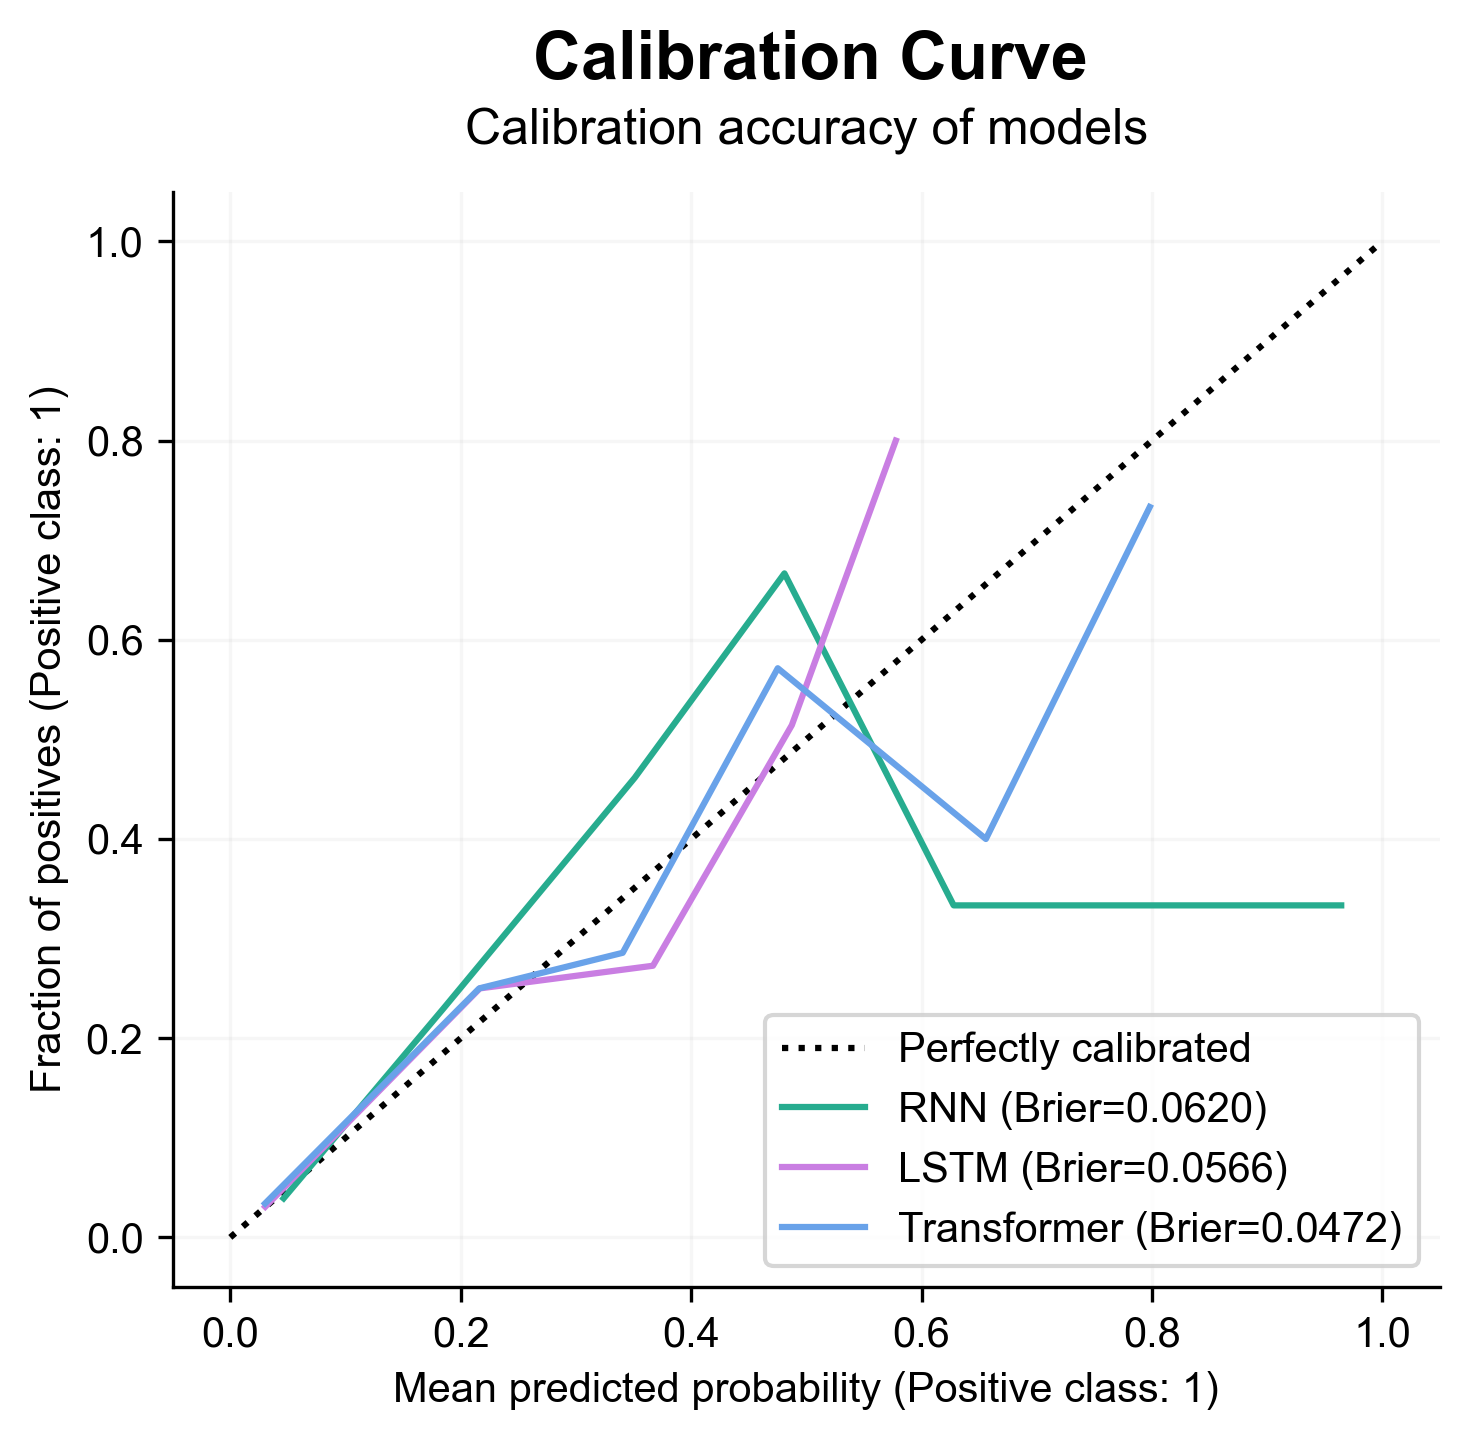

In [75]:
from sklearn.calibration import CalibrationDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import brier_score_loss

# set font to Arial
plt.rcParams['font.sans-serif'] = 'Arial'

plt.figure(figsize=(5, 5), dpi=300)
ax_roc_auc_curve = plt.axes()

brier_rnn = brier_score_loss(y_test_rnn, calibrated_predictions_rnn)
brier_lstm = brier_score_loss(y_test_lstm, calibrated_predictions_lstm)
brier_transformer = brier_score_loss(y_test_transf, calibrated_predictions_transf)

strategy = 'uniform'
n_bins = 7

CalibrationDisplay.from_predictions(
    y_test_rnn, 
    calibrated_predictions_rnn, 
    ax=ax_roc_auc_curve, 
    name="RNN",
    label=f'RNN (Brier={brier_rnn:.4f})',
    color=colors[0],
    n_bins=n_bins,
    strategy=strategy,
    marker=None
)
CalibrationDisplay.from_predictions(
    y_test_lstm, 
    calibrated_predictions_lstm, 
    ax=ax_roc_auc_curve, 
    name="LSTM",
    label=f'LSTM (Brier={brier_lstm:.4f})',
    color=colors[1],
    n_bins=n_bins,
    strategy=strategy,
    marker=None
)
CalibrationDisplay.from_predictions(
    y_test_transf,
    calibrated_predictions_transf,
    ax=ax_roc_auc_curve,
    name="Transformer",
    label=f'Transformer (Brier={brier_transformer:.4f})',
    color=colors[2],
    n_bins=n_bins,
    strategy=strategy,
    marker=None
)

# disable right and upper spines
ax_roc_auc_curve.spines["right"].set_visible(False)
ax_roc_auc_curve.spines["top"].set_visible(False)

# disable grid
ax_roc_auc_curve.grid(alpha=0.1)

plt.suptitle("Calibration Curve", fontsize=16, y=0.95, fontweight='bold', x=0.55)
plt.title("Calibration accuracy of models", fontsize=12, y=1.02, fontweight='light', loc='center')


plt.tight_layout()
plt.show()